<a href="https://colab.research.google.com/github/pravin-raut/MachineLearning/blob/Master/dissertation/Currency_Forecast_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pmdarima
!pip install quandl
!pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.7 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime,timedelta
import json
import quandl

In [4]:
import urllib.request

file_path = "https://raw.githubusercontent.com/pravin-raut/MachineLearning/Master/dissertation/Config/Config_Git.json"

# Open the file for reading and load the data from it
with urllib.request.urlopen(file_path) as infile:
  data = json.load(infile)
# Set up API key
  api_key=data["nasdaq"]["api_key"]
quandl.ApiConfig.api_key = api_key


In [5]:
CurrentDate = (datetime.today() - timedelta(days=0)).strftime('%Y-%m-%d')
CurrentDate


'2023-07-07'

In [6]:
FirstDay='2019-01-01'


In [7]:

def getDataFromAPI(API,symbol,start_date,end_date):

  if API=="YFinance":
    # Create a ticker object
    ticker = yf.Ticker(symbol)
    # Download historical data
    data = ticker.history(period="1d", start=start_date, end=end_date)

  if API=="Nasdaq":
    data = quandl.get(symbol,start_date=start_date,end_date=end_date)


  return data

In [8]:
df_USD_EUR=getDataFromAPI("YFinance","EURUSD=X",FirstDay,CurrentDate).reset_index()
df_USD_EUR['Date'] = pd.to_datetime(df_USD_EUR['Date']).dt.date
df_USD_EUR.set_index('Date', inplace=True)
df_USD_EUR=df_USD_EUR.asfreq('b')
df_USD_EUR.Close=df_USD_EUR.Close.fillna(method='bfill')
df_USD_EUR['Original_USD_EUR_Price']=df_USD_EUR[['Close']]
df_USD_EUR=df_USD_EUR[['Original_USD_EUR_Price']]
df_USD_EUR

,Original_USD_EUR_Price
Date,
2019-01-01,1.149306
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044
...,...
2023-06-30,1.086803
2023-07-03,1.090750
2023-07-04,1.091310


In [9]:
from statsmodels.tsa.stattools import adfuller

def perform_adfuller(series):
    # Perform Augmented Dickey-Fuller test
    result = adfuller(series)

    # Extract test statistics and p-value
    test_statistic = result[0]
    p_value = result[1]

    # Print the results
    print("Augmented Dickey-Fuller Test:")
    print(f"Test Statistic: {test_statistic}")
    print(f"P-value: {p_value}")

    # Check the p-value against a significance level (e.g., 0.05) to determine stationarity
    if p_value <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is non-stationary.")



In [10]:
perform_adfuller(df_USD_EUR['Original_USD_EUR_Price'].diff(1).dropna())

Augmented Dickey-Fuller Test:
Test Statistic: -33.210157588564854
P-value: 0.0
The time series is stationary.


In [11]:
# Define the start and end dates for train and test data
train_start_date = pd.to_datetime('2018-01-01')
train_end_date = pd.to_datetime('2022-05-31')
test_start_date = pd.to_datetime('2023-01-01')


In [12]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import matplotlib.pyplot as plt

def plot_acf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_acf(data.dropna(), lags=lags, ax=ax,zero=False)
    plt.title('ACF')
    plt.show()

def plot_pacf_values(data, lags):
    fig, ax = plt.subplots(figsize=(12, 4))
    plot_pacf(data.dropna(), lags=lags, ax=ax,zero=False,alpha=0.05)
    plt.title('PACF')
    plt.show()


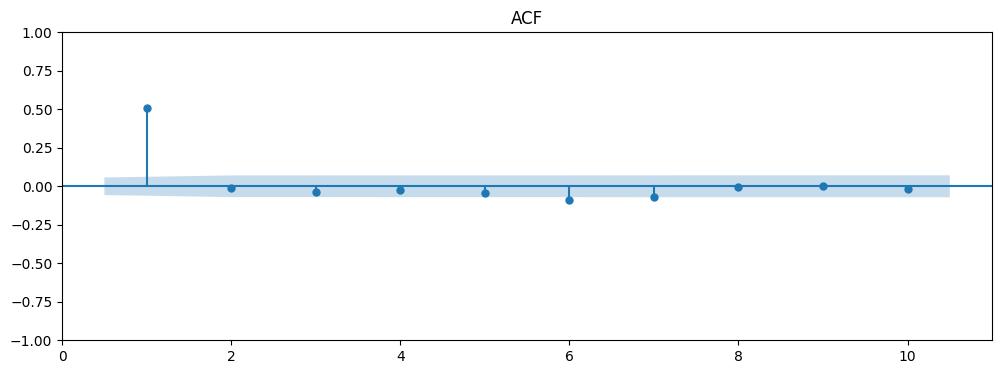

/usr/local/lib/python3.10/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


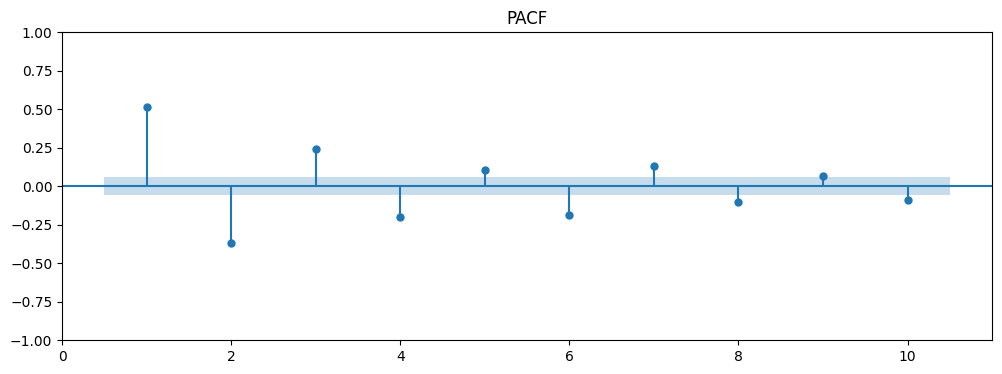

In [13]:
plot_acf_values(df_USD_EUR['Original_USD_EUR_Price'].diff(2),10)
plot_pacf_values(df_USD_EUR['Original_USD_EUR_Price'].diff(2),10)

In [14]:
train_data_currency = df_USD_EUR[(df_USD_EUR.index >= train_start_date) & (df_USD_EUR.index <= train_end_date)]
test_data_currency = df_USD_EUR[df_USD_EUR.index >= test_start_date]
train_data_currency.head(5)

,Original_USD_EUR_Price
Date,
2019-01-01,1.149306
2019-01-02,1.146171
2019-01-03,1.131811
2019-01-04,1.139108
2019-01-07,1.141044


In [15]:
from pmdarima import auto_arima
model = auto_arima(train_data_currency['Original_USD_EUR_Price'].dropna(),
                   start_p=1, start_q=1,d=2,min_p=1,
                         seasonal=False,   # No Seasonality
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
model.summary()


Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-6876.706, Time=2.85 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-6448.031, Time=0.19 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-6705.217, Time=0.23 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-6891.154, Time=0.56 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-6450.030, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-6940.806, Time=2.37 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-6920.145, Time=1.01 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-6970.585, Time=1.66 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-6957.689, Time=2.20 sec
 ARIMA(0,2,4)(0,0,0)[0] intercept   : AIC=-6924.230, Time=5.21 sec
 ARIMA(1,2,4)(0,0,0)[0] intercept   : AIC=-6986.869, Time=3.89 sec
 ARIMA(2,2,4)(0,0,0)[0] intercept   : AIC=-6980.924, Time=3.27 sec
 ARIMA(1,2,5)(0,0,0)[0] intercept   : AIC=-7005.774, Time=5.29 sec
 ARIMA(0,2,5)(0,0,0)[0] intercept   : AIC=-6991.241, Time=2.83 sec
 ARIMA(2,2,5)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  891
Model:               SARIMAX(0, 2, 5)   Log Likelihood                3511.430
Date:                Fri, 07 Jul 2023   AIC                          -7010.860
Time:                        06:54:53   BIC                          -6982.120
Sample:                    01-01-2019   HQIC                         -6999.875
                         - 05-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9299      0.031    -29.851      0.000      -0.991      -0.869
ma.L2          0.0205      0.041      0.498      0.618      -0.060       0.101
ma.L3         -0.1652      0.038     -4.388      0.000      -0.239      -0.091
ma.L4          0.0409      0.040      1.011      0.312      -0.038       0.120
ma.L5          0.0519      0.032      1.621      0.105      -0.011       0.115
sigma2       2.16e-05   7.75e-07     27.873      0.000    2.01e-05    2.31e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.56   Jarque-Bera (JB):               211.85
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               1.83   Skew:                            -0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [16]:
import warnings
warnings.filterwarnings("ignore")


In [17]:
from pmdarima.arima import ndiffs
kpss_diff = ndiffs(train_data_currency['Original_USD_EUR_Price'].values, alpha=0.05, test='kpss', max_d=12)
adf_diff = ndiffs(train_data_currency['Original_USD_EUR_Price'].values, alpha=0.05, test='adf', max_d=12)
n_diffs = max(adf_diff , kpss_diff )
n_diffs

1

In [18]:
from statsmodels.tsa.arima.model import ARIMA

cur_model=ARIMA(train_data_currency['Original_USD_EUR_Price'],order=(1,2,4))
cur_model_fit=cur_model.fit()
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Original_USD_EUR_Price   No. Observations:                  891
Model:                     ARIMA(1, 2, 4)   Log Likelihood                3515.764
Date:                    Fri, 07 Jul 2023   AIC                          -7019.527
Time:                            06:55:25   BIC                          -6990.787
Sample:                        01-01-2019   HQIC                         -7008.542
                             - 05-31-2022                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8576      0.318     -2.696      0.007      -1.481      -0.234
ma.L1         -0.0987      0.321     -0.308      0.758      -0.727       0.530
ma.L2         -0.8138      0.302     -2.693      0.007      -1.406      -0.222
ma.L3         -0.0285      0.033     -0.864      0.388      -0.093       0.036
ma.L4         -0.0548      0.029     -1.907      0.056      -0.111       0.002
sigma2      2.129e-05   7.55e-07     28.209      0.000    1.98e-05    2.28e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               228.67
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.22
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [20]:
from statsmodels.tsa.arima.model import ARIMA

cur_model=ARIMA(train_data_currency['Original_USD_EUR_Price'],order=(5,1,1))
cur_model_fit=cur_model.fit()
cur_model_fit.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:     Original_USD_EUR_Price   No. Observations:                  891
Model:                     ARIMA(5, 1, 1)   Log Likelihood                3524.152
Date:                    Fri, 07 Jul 2023   AIC                          -7034.304
Time:                            06:56:01   BIC                          -7000.766
Sample:                        01-01-2019   HQIC                         -7021.485
                             - 05-31-2022                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0187      0.016      1.189      0.235      -0.012       0.049
ar.L2          0.0411      0.028      1.456      0.145      -0.014       0.096
ar.L3         -0.0282      0.029     -0.974      0.330      -0.085       0.029
ar.L4         -0.0356      0.031     -1.150      0.250      -0.096       0.025
ar.L5         -0.0012      0.025     -0.048      0.962      -0.050       0.048
ma.L1          0.0184      0.016      1.162      0.245      -0.013       0.049
sigma2      2.125e-05   7.29e-07     29.161      0.000    1.98e-05    2.27e-05
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               247.97
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               1.84   Skew:                            -0.27
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.13e+16. Standard errors may be unstable.
"""

In [21]:
# Get in-sample predictions
training_data_predictions = cur_model_fit.get_prediction(start=train_data_currency.dropna().index.min(),
                                                      end=train_data_currency.dropna().index.max(),
                                                      dynamic=False)

train_data_currency[['lower Cur predictions','Higher Oil predictions']] = training_data_predictions.conf_int()

# Create a new column for the predicted values
train_data_currency['Cur predictions'] = training_data_predictions.predicted_mean

train_data_currency

,Original_USD_EUR_Price,lower Cur predictions,Higher Oil predictions,Cur predictions
Date,,,,
2019-01-01,1.149306,-1959.963985,1959.963985,0.000000
2019-01-02,1.146171,1.140248,1.158365,1.149306
2019-01-03,1.131811,1.136998,1.155103,1.146051
2019-01-04,1.139108,1.122115,1.140206,1.131160
2019-01-07,1.141044,1.129878,1.147961,1.138920
...,...,...,...,...
2022-05-25,1.073653,1.059498,1.077569,1.068533
2022-05-26,1.068661,1.064931,1.083003,1.073967
2022-05-27,1.073295,1.059362,1.077434,1.068398


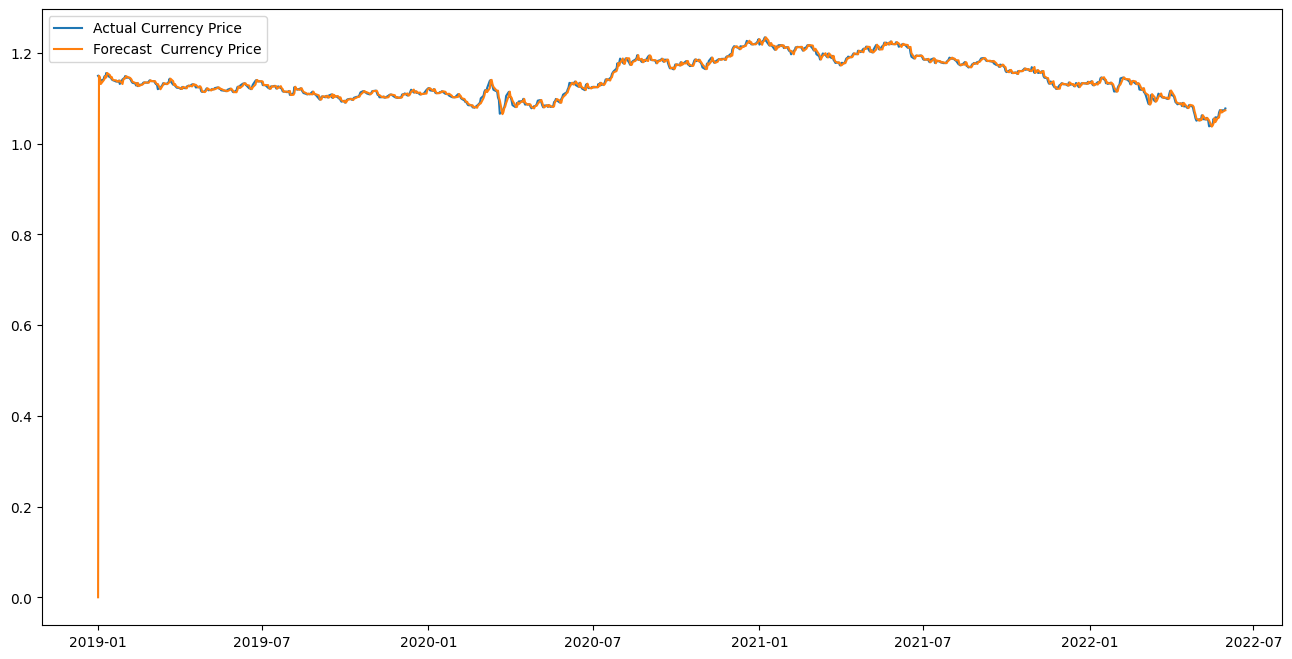

In [22]:
plt.figure(figsize=(16,8))
plt.plot(train_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(train_data_currency['Cur predictions'],label="Forecast  Currency Price")
plt.legend(loc="upper left")

In [29]:
import pandas as pd

# define train test data
train = train_data_currency['Original_USD_EUR_Price'].dropna()
test = test_data_currency['Original_USD_EUR_Price'].dropna()

# define model configuration
my_order = (5,1,1)

# lists to collect forecasts
forecasts = []
forecast_dates = []

# walk-forward validation
history = [x for x in train]
for i in range(len(test)):
    if i % 5==0:
      #auto = auto_arima(history, error_action='ignore', suppress_warnings=True,d=2)
      #my_order = auto.order
      print("my_order is {}".format(my_order))
      model = ARIMA(history, order=my_order)
      model_fit = model.fit()
    forecast = model_fit.get_forecast(steps=1, alpha=0.05)
    forecasts.append(forecast.predicted_mean[0])
    forecast_dates.append(test.index[i])
    history.append(forecast.predicted_mean[0])
    #print("Length of History is {} for date{} and order {} forecast is {}",format((len(history),test.index[i],my_order,forecast.predicted_mean[0])))
# Create a dataframe to hold the forecasts with corresponding dates
forecast_df = pd.DataFrame(data={'Forecast': forecasts}, index=forecast_dates)



my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)
my_order is (5, 1, 1)


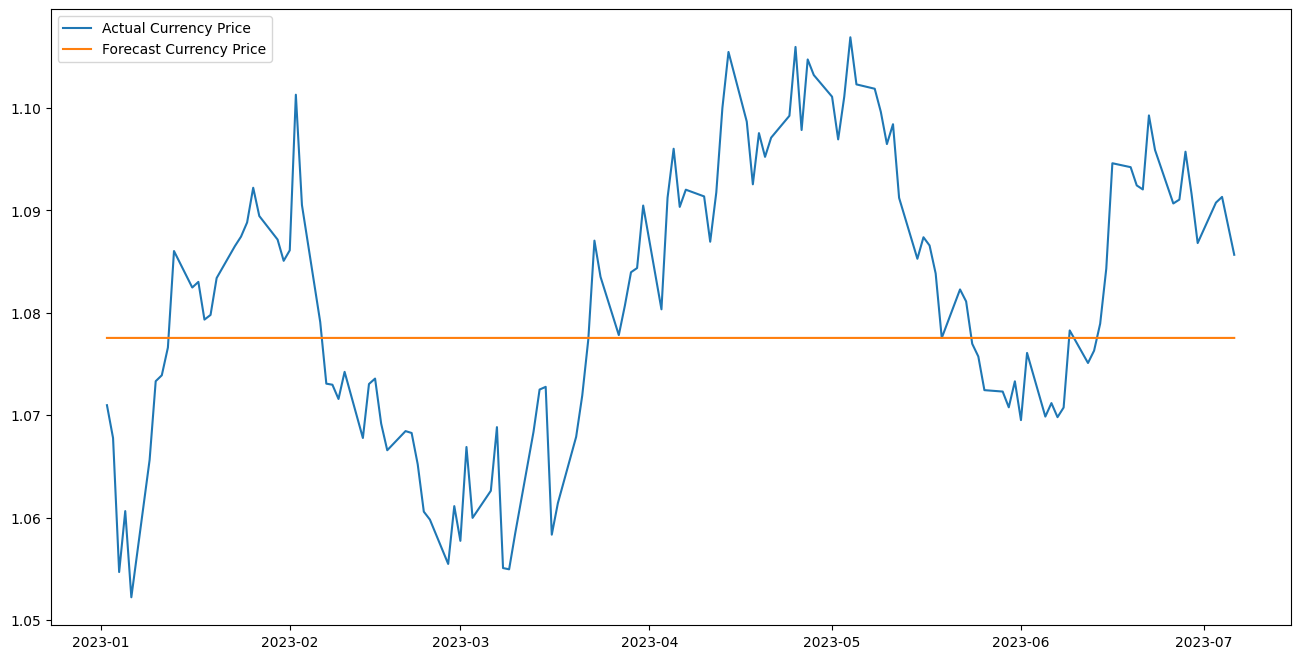

In [30]:
plt.figure(figsize=(16,8))
plt.plot(test_data_currency['Original_USD_EUR_Price'],label="Actual Currency Price")
plt.plot(forecast_df['Forecast'],label="Forecast Currency Price")

plt.legend(loc="upper left")
plt.show()


In [27]:

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

def calculate_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return {"Mean Absolute Error": mae, "Mean Squared Error": mse, "Root Mean Squared Error": rmse, "Mean Absolute Percentage Error": mape}



In [31]:

metrics = calculate_metrics(test_data_currency['Original_USD_EUR_Price'].dropna(), forecast_df['Forecast'].dropna())
metrics

{'Mean Absolute Error': 0.011804281746529552,
 'Mean Squared Error': 0.00019431831487849062,
 'Root Mean Squared Error': 0.013939810431942416,
 'Mean Absolute Percentage Error': 1.0888507578101236}